In [125]:
import ROOT as rt
# import root_numpy as rtnp
import csv
import re
import sys
import collections

from collections import OrderedDict
import uproot
import pandas as pd

import scipy
import awkward
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
sys.path.append('/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot
from helper_functions import deltaR
import CMS_lumi, tdrstyle
a = tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0

print(sys.version)

3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


# Load ntuples

In [2]:
fpath =OrderedDict()
tree = OrderedDict()


start_t = time.time()



isData = 0

ntupler_version = 'V1p17/'
analyzer_version = "/v1/v165/" #new acceptance definition



decay = 'dddd'
mass = [ '7', '15', '40','55']
ctaus  = ['100','1000','10000','100000']
for ct in ctaus:
    for m in mass:
        mc_path = '/storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+ntupler_version+'/MC_all/'+analyzer_version+'/normalized/'
        fpath['m'+m+'ctau'+ct] = mc_path + 'ggH_HToSSTo'+decay+'_MH-125_MS-'+str(m)+'_ctau-'+ct+'_137000pb_weighted.root'

for k,v in fpath.items():
    print (k, v)
    root_dir = uproot.open(v) 
    tree[k] = root_dir['MuonSystem']
   



m7ctau100 /storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17//MC_all//v1/v165//normalized/ggH_HToSSTodddd_MH-125_MS-7_ctau-100_137000pb_weighted.root
m15ctau100 /storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17//MC_all//v1/v165//normalized/ggH_HToSSTodddd_MH-125_MS-15_ctau-100_137000pb_weighted.root
m40ctau100 /storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17//MC_all//v1/v165//normalized/ggH_HToSSTodddd_MH-125_MS-40_ctau-100_137000pb_weighted.root
m55ctau100 /storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17//MC_all//v1/v165//normalized/ggH_HToSSTodddd_MH-125_MS-55_ctau-100_137000pb_weighted.root
m7ctau1000 /storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17//MC_all//v1/v165//normalized/ggH_HToSSTodddd_MH-125_MS-7_ctau-1000_137000pb_weighted.root
m15ctau1000 /storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17//MC_all//v1/v165/

# one tag

In [111]:
gLLP_eta ={}
gLLP_decay_vertex_r = {}
gLLP_decay_vertex_z = {}
gLLP_match_cscRechits = {}
gLLP_match_dtRechits = {}
cscRechitClusterNStation10 = {}
cscRechitClusterEta = {}
cscRechitClusterAvgStation10= {}
sel_ev = {}
bdt_sel ={}
cluster_index = ''

for k, T in tree.items():
    if not k[-4:]=='1000':continue
    sel_llp = np.logical_or(T.array('gLLP_dt'), T.array('gLLP_csc'))
    one_tag =np.sum(sel_llp, axis = 1)==1
    sel_llp = sel_llp[one_tag]
    gLLP_eta[k] = T.array('gLLP_eta')[one_tag][sel_llp]
    gLLP_decay_vertex_r[k] = T.array('gLLP_decay_vertex_r')[one_tag][sel_llp]
    gLLP_decay_vertex_z[k] = T.array('gLLP_decay_vertex_z')[one_tag][sel_llp]
    gLLP_match_cscRechits[k] = T.array('gLLP_match_cscRechits')[one_tag][sel_llp]
    gLLP_match_dtRechits[k] = T.array('gLLP_match_dtRechits')[one_tag][sel_llp]

    
    sel_rechitcluster = np.abs(T.array('cscRechitCluster' + cluster_index + 'Eta')) < 2.0
    me1112_veto = 0
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus11') <= me1112_veto)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus12') <= me1112_veto)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus11') <= me1112_veto)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus12') <= me1112_veto)
    
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + '_match_MB1Seg_0p4') <= me1112_veto)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + '_match_RE12_0p4') <= me1112_veto)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + '_match_RB1_0p4') <= me1112_veto)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'TimeSpread') <= 20)
    sel_rechitcluster = np.logical_and(sel_rechitcluster, np.logical_and(T.array('cscRechitCluster' + cluster_index + 'TimeTotal') < 12.5, T.array('cscRechitCluster' + cluster_index + 'TimeTotal') > -5.0))
    sel_rechitcluster = np.logical_and( sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'JetVetoPt') < 10)
    sel_rechitcluster = np.logical_and( sel_rechitcluster, T.array('cscRechitCluster' + cluster_index + 'MuonVetoPt') < 20)
    cscRechitClusterNStation10[k] = T.array('cscRechitCluster' + cluster_index + 'NStation10')
    cscRechitClusterEta[k] = T.array('cscRechitCluster' + cluster_index + 'Eta')
    cscRechitClusterAvgStation10[k] = T.array('cscRechitCluster' + cluster_index + 'AvgStation10')
    
    cond2 = np.logical_and(np.abs(cscRechitClusterAvgStation10[k])==2, np.abs(cscRechitClusterEta[k]) < 1.6)
    cond3 = np.logical_and(np.abs(cscRechitClusterAvgStation10[k])==3, np.abs(cscRechitClusterEta[k]) < 1.6)
    cond4 = np.logical_and(np.abs(cscRechitClusterAvgStation10[k])==4, np.abs(cscRechitClusterEta[k]) < 1.8)
    cond1 = np.logical_and(cscRechitClusterNStation10[k]==1, np.logical_or(np.logical_or(np.abs(cscRechitClusterAvgStation10[k])==1, cond2), np.logical_or(cond3, cond4)))
    cond2 = np.logical_and(cscRechitClusterNStation10[k] > 1, np.abs(cscRechitClusterEta[k]) < 1.9)
    bdt_sel = np.logical_or(np.logical_or(cond1, cond2), np.logical_or(cond3, cond4))
    
    sel_rechitcluster =np.logical_and(sel_rechitcluster, bdt_sel)
    sel_ev[k] = np.logical_and(np.sum(np.logical_or(T.array('gLLP_dt'), T.array('gLLP_csc')), axis = 1)==1, sel_rechitcluster.sum()>=1)
    

    
    sel_ev[k] = sel_ev[k][np.sum(np.logical_or(T.array('gLLP_dt'), T.array('gLLP_csc')), axis = 1)==1]
                
    # LLP decayed in overlap region
    eta_overlap = np.logical_and(np.abs(gLLP_eta[k]).flatten()<1.3, np.abs(gLLP_eta[k]).flatten()>0.7)
    # LLP created "cluster" in overlap region
    match_hits = np.logical_and(np.abs(gLLP_match_cscRechits[k]).flatten()>20, gLLP_match_dtRechits[k]>20)
    
    print(k, np.count_nonzero(eta_overlap), np.count_nonzero(match_hits), np.count_nonzero(np.logical_and(sel_ev[k], match_hits))/np.count_nonzero(match_hits))


m7ctau1000 6686 1650 0.1503030303030303
m15ctau1000 6781 2225 0.15685393258426966
m40ctau1000 4323 1797 0.11018363939899833
m55ctau1000 2523 1134 0.03880070546737213


# two tag

In [202]:
gLLP_eta ={}
gLLP_phi = {}
dR = {}
gLLP_decay_vertex_r = {}
gLLP_decay_vertex_z = {}
gLLP_match_cscRechits = {}
gLLP_match_dtRechits = {}
cscRechitClusterNStation10 = {}
cscRechitClusterEta = {}
cscRechitClusterAvgStation10= {}
sel_ev = {}
bdt_sel ={}
cluster_index = ''

for k, T in tree.items():
    if not k[-4:]=='1000':continue
    sel_llp = np.logical_or(T.array('gLLP_dt'), T.array('gLLP_csc'))
#     sel_llp =  T.array('gLLP_csc')
    two_tag =np.sum(sel_llp, axis = 1)==2
    gLLP_eta[k] = T.array('gLLP_eta')[two_tag]
    gLLP_phi[k] = T.array('gLLP_phi')[two_tag]
    gLLP_decay_vertex_r[k] = T.array('gLLP_decay_vertex_r')[two_tag]
    gLLP_decay_vertex_z[k] = T.array('gLLP_decay_vertex_z')[two_tag]
    gLLP_match_cscRechits[k] = T.array('gLLP_match_cscRechits')[two_tag]
    gLLP_match_dtRechits[k] = T.array('gLLP_match_dtRechits')[two_tag]
    dR[k] = deltaR(gLLP_eta[k][:,0], gLLP_phi[k][:,0], gLLP_eta[k][:,1], gLLP_phi[k][:,1])
    
    ################################ cluster level selections #######################
    sel_csccluster = T.array('cscRechitCluster' + cluster_index + 'TimeSpreadWeightedAll')<20
    sel_csccluster = np.logical_and(sel_csccluster, np.abs(T.array('cscRechitCluster' + cluster_index + 'MetEENoise_dPhi'))<1.2)
    sel_csccluster = np.logical_and(sel_csccluster, T.array('cscRechitCluster' + cluster_index + 'JetVetoPt')<30)
    sel_csccluster = np.logical_and(sel_csccluster, T.array('cscRechitCluster' + cluster_index + 'Me11Ratio')<1)
    sel_csccluster = np.logical_and(sel_csccluster, np.logical_not(np.logical_and(T.array('cscRechitClusterMuonVetoPt') >= 30, T.array('cscRechitClusterMuonVetoGlobal'))))

    sel_csccluster = np.logical_and(sel_csccluster, np.logical_and(T.array('cscRechitCluster' + cluster_index + 'TimeWeighted')+0.66 < 12.5, \
                                                                         T.array('cscRechitCluster' + cluster_index + 'TimeWeighted')+0.66 > -5))
 

    sel_loosecsccluster = T.array('cscRechitCluster' + cluster_index + 'TimeSpreadWeightedAll')<20
    sel_loosecsccluster = np.logical_and(sel_loosecsccluster, np.abs(T.array('cscRechitCluster' + cluster_index + 'MetEENoise_dPhi'))<1.2)
    sel_loosecsccluster = np.logical_and(sel_loosecsccluster, T.array('cscRechitCluster' + cluster_index + 'JetVetoPt')<30)
    sel_loosecsccluster = np.logical_and(sel_loosecsccluster, T.array('cscRechitCluster' + cluster_index + 'Me11Ratio')<1)
    sel_loosecsccluster = np.logical_and(sel_loosecsccluster, np.logical_not(np.logical_and(T.array('cscRechitClusterMuonVetoPt') >= 30, T.array('cscRechitClusterMuonVetoGlobal'))))

    sel_loosecsccluster = np.logical_and(sel_loosecsccluster, np.logical_and(T.array('cscRechitCluster' + cluster_index + 'TimeWeighted')+0.66 < 12.5, \
                                                                         T.array('cscRechitCluster' + cluster_index + 'TimeWeighted')+0.66 > -5))
 
    sel_loosecsccluster = T.array('cscRechitCluster' + cluster_index + 'TimeSpreadWeightedAll')<20
    sel_loosecsccluster = np.logical_and(sel_loosecsccluster, np.abs(T.array('cscRechitCluster' + cluster_index + 'MetEENoise_dPhi'))<1.2)
#     sel_loosecsccluster = np.logical_and(sel_loosecsccluster, T.array('cscRechitCluster' + cluster_index + 'JetVetoPt')<30)
#     sel_loosecsccluster = np.logical_and(sel_loosecsccluster, T.array('cscRechitCluster' + cluster_index + 'Me11Ratio')<1)
#     sel_loosecsccluster = np.logical_and(sel_loosecsccluster, np.logical_not(np.logical_and(T.array('cscRechitClusterMuonVetoPt') >= 30, T.array('cscRechitClusterMuonVetoGlobal'))))

    sel_loosecsccluster = np.logical_and(sel_loosecsccluster, np.logical_and(T.array('cscRechitCluster' + cluster_index + 'TimeWeighted')+0.66 < 12.5, \
                                                                         T.array('cscRechitCluster' + cluster_index + 'TimeWeighted')+0.66 > -5))

    sel_ev[k]  = np.logical_and((sel_csccluster.sum()>=1)[two_tag], dR[k]>0.4)
    sel_ev[k]  = np.logical_and(sel_ev[k], (sel_loosecsccluster.sum()>=2)[two_tag])
#     sel_ev[k] = sel_ev[k][np.sum(np.logical_or(T.array('gLLP_dt'), T.array('gLLP_csc')), axis = 1)==1]
                
    # LLP decayed in overlap region
    eta_overlap = np.logical_and(np.abs(gLLP_eta[k])<1.3, np.abs(gLLP_eta[k])>0.7)
    # LLP created "cluster" in overlap region
    match_hits = np.logical_and(np.abs(gLLP_match_cscRechits[k])>30, gLLP_match_dtRechits[k]>20)
    both = np.logical_and(eta_overlap, match_hits)
#     print(k, np.count_nonzero(np.sum(both,axis=1)==0), np.count_nonzero(np.sum(both,axis=1)==1), np.count_nonzero(np.sum(both,axis=1)==2))

    print(k, np.count_nonzero(np.logical_and(dR[k]>0.4,np.sum(both,axis=1)==0)),np.count_nonzero(np.logical_and(dR[k]>0.4,np.sum(both,axis=1)==1)),\
          np.count_nonzero(np.logical_and(dR[k]>0.4,np.sum(both,axis=1)==2)))
          
        
    print(k, np.count_nonzero(np.logical_and(sel_ev[k],np.sum(both,axis=1)==1))/np.count_nonzero(np.sum(both,axis=1)==1),
          np.count_nonzero(np.logical_and(sel_ev[k],np.sum(both,axis=1)==2))/np.count_nonzero(np.sum(both,axis=1)==1))
#     print(gLLP_eta[k][np.sum(both,axis=1)==2])

m7ctau1000 1472 216 7
m7ctau1000 0.20833333333333334 0.023148148148148147
m15ctau1000 2608 499 26
m15ctau1000 0.2565130260521042 0.04008016032064128
m40ctau1000 2578 649 86
m40ctau1000 0.2440119760479042 0.03293413173652695
m55ctau1000 956 207 62
m55ctau1000 0.017632241813602016 0.007556675062972292


In [183]:
gLLP_eta ={}
gLLP_phi = {}
dR = {}
gLLP_decay_vertex_r = {}
gLLP_decay_vertex_z = {}
gLLP_match_cscRechits = {}
gLLP_match_dtRechits = {}
cscRechitClusterNStation10 = {}
cscRechitClusterEta = {}
cscRechitClusterAvgStation10= {}
sel_ev = {}
bdt_sel ={}
cluster_index = ''

for k, T in tree.items():
    if not k[-4:]=='1000':continue
    sel_llp = np.logical_and(np.abs(T.array('gLLP_decay_vertex_z'))<700, np.abs(T.array('gLLP_decay_vertex_z'))>550)
    sel_llp = np.logical_and(sel_llp, T.array('gLLP_decay_vertex_r')<400)
    sel_llp = np.logical_and(sel_llp, T.array('gLLP_decay_vertex_r')>300)

#     sel_llp = np.logical_and(sel_llp, T.array('gLLP_decay_vertex_r')<600)
#     sel_llp = np.logical_and(sel_llp, T.array('gLLP_decay_vertex_r')>450)
    ################################ cluster level selections #######################
    sel_csccluster = T.array('cscRechitCluster' + cluster_index + 'TimeSpreadWeightedAll')<20
    sel_csccluster = np.logical_and(sel_csccluster, np.abs(T.array('cscRechitCluster' + cluster_index + 'MetEENoise_dPhi'))<1.2)
    sel_csccluster = np.logical_and(sel_csccluster, T.array('cscRechitCluster' + cluster_index + 'JetVetoPt')<30)
    sel_csccluster = np.logical_and(sel_csccluster, T.array('cscRechitCluster' + cluster_index + 'Me11Ratio')<1)
    sel_csccluster = np.logical_and(sel_csccluster, np.logical_not(np.logical_and(T.array('cscRechitClusterMuonVetoPt') >= 30, T.array('cscRechitClusterMuonVetoGlobal'))))

    sel_csccluster = np.logical_and(sel_csccluster, np.logical_and(T.array('cscRechitCluster' + cluster_index + 'TimeWeighted')+0.66 < 12.5, \
                                                                         T.array('cscRechitCluster' + cluster_index + 'TimeWeighted')+0.66 > -5))
 


# #     sel_ev[k] = sel_ev[k][np.sum(np.logical_or(T.array('gLLP_dt'), T.array('gLLP_csc')), axis = 1)==1]
                
#     # LLP decayed in overlap region
#     eta_overlap = np.logical_and(np.abs(gLLP_eta[k])<1.3, np.abs(gLLP_eta[k])>0.7)
#     # LLP created "cluster" in overlap region
#     match_hits = np.logical_and(np.abs(gLLP_match_cscRechits[k])>30, gLLP_match_dtRechits[k]>20)
#     both = np.logical_and(eta_overlap, match_hits)
# #     print(k, np.count_nonzero(np.sum(both,axis=1)==0), np.count_nonzero(np.sum(both,axis=1)==1), np.count_nonzero(np.sum(both,axis=1)==2))

#     print(k, np.count_nonzero(np.logical_and(dR[k]>0.4,np.sum(both,axis=1)==0)),np.count_nonzero(np.logical_and(dR[k]>0.4,np.sum(both,axis=1)==1)),\
#           np.count_nonzero(np.logical_and(dR[k]>0.4,np.sum(both,axis=1)==2)))
          
    print(k, np.count_nonzero(np.logical_and(np.sum(sel_llp, axis=1)==1, sel_csccluster.sum()>=1))/np.count_nonzero(np.sum(sel_llp, axis=1)==1))

m7ctau1000 0.782246879334258
m15ctau1000 0.866948257655755
m40ctau1000 0.8943850267379679
m55ctau1000 0.749034749034749


In [167]:
m7ctau1000 0.6680988184747583
m15ctau1000 0.8007380073800738
m40ctau1000 0.8449197860962567
m55ctau1000 0.5622568093385214

0.5555555555555556

# different mass points

In [180]:
66/78

0.8461538461538461

m7ctau100 0.3847695390781563
m15ctau100 0.5238623751387348
m40ctau100 0.7884615384615384
m55ctau100 0.6923076923076923
m7ctau1000 0.2105892910559378
m15ctau1000 0.2875682052794573
m40ctau1000 0.37404580152671757
m55ctau1000 0.40626238604835513
m7ctau10000 0.15461493239271018
m15ctau10000 0.19550063371356147
m40ctau10000 0.26096997690531176
m55ctau10000 0.3065654782915637
m7ctau100000 0.16990291262135923
m15ctau100000 0.16953316953316952
m40ctau100000 0.25925925925925924
m55ctau100000 0.24672708962739173


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potenti

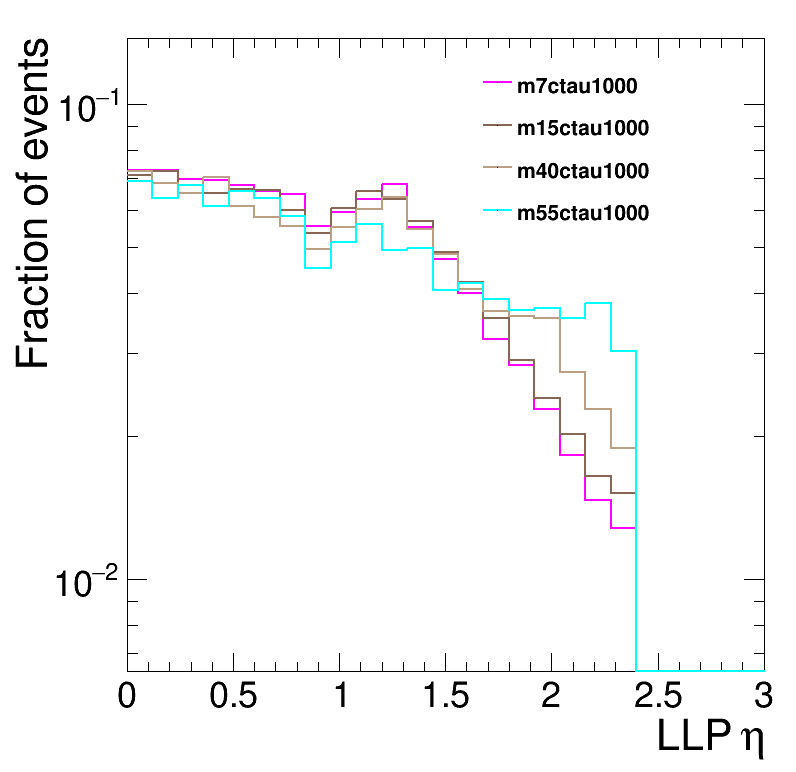

In [51]:


# var = [gLLP_eta, gLLP_decay_vertex_r, gLLP_decay_vertex_z, gLLP_match_cscRechits, gLLP_match_dtRechits]
# name = ['gLLP_eta', 'gLLP_decay_vertex_r', 'gLLP_decay_vertex_z', 'gLLP_match_cscRechits', 'gLLP_match_dtRechits', 'cscRechitClusterMe11Ratio',\
#        'deltaRCluster', 'deltaEta', 'cscRechitClusterEta', 'cscRechitClusterPhi', 'cscRechitClusterAvgStation', 'clusterDphi']

# xaxis = ['cluster time [ns]', 'max cluster time spread [ns]', 'max jet veto p_{T} [GeV]','max muon veto p_{T} [GeV]', 'max #Delta#phi(met, cluster)', 'max N_{ME11 hits}/N_{rechits}',\
#         '#Delta R(cluster1, cluster2)', '#Delta#eta(cluster1, cluster2)', 'cluster #eta', 'cluster #phi', 'cluster average station', '#Delta#phi(cluster1, cluster2)']

# # bins = [ [100,-100,120], [50,0,100], [50,0,500],[50,0,200], [32,0,3.2], [25,0,1.1],[25,0.8,2.5],[30,0,3.2],[35,1,4], [40,0,3.2], [40,0,8], [40,0,5]]

# bins = [ [100,-100,120], [50,0,100], [50,0,500],[50,0,200], [32,0,3.2], [22,0,1.1],[40,0,8], [40,0,5], [25,0.8,2.5],[25,0,3.2],[20,1,4], [25,0,3.2]]

# setlogy = [1,1,1,1,1,1,1,1,1,1,1,1]

c = rt.TCanvas('c','c', 800, 800)
leg = rt.TLegend(0.6,0.7,0.80,0.92)

#     leg = rt.TLegend(0.5,0.56,0.75,0.92)

leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
h = {}

for i, k in enumerate(tree.keys()):
    


    h[k] = create_TH1D(np.abs(gLLP_eta[k]).flatten(), axis_title = ['LLP #eta', 'Fraction of events'], binning = [25,0,3])
#         if index == 0: h[k] = create_TH1D(np.hstack((var[index][k][sel_csccluster][cond][:,0], var[index][k][sel_csccluster][cond][:,1])), axis_title = [xaxis[index], 'Fraction of events'], binning = bins[index])
#         elif index == 8 or index == 9 or index == 10:h[k] = create_TH1D(np.abs(np.hstack((var[index][k][sel_csccluster][cond][:,0], var[index][k][sel_csccluster][cond][:,1]))), axis_title = [xaxis[index], 'Fraction of events'], binning = bins[index])
#         elif index == 6 or index == 7 or index == 11:h[k] = create_TH1D(np.abs(var[index][k][cond]), axis_title = [xaxis[index], 'Fraction of events'], binning = bins[index])
#         else: h[k] = create_TH1D(var[index][k][sel_csccluster][cond].max(), axis_title = [xaxis[index], 'Fraction of events'], binning = bins[index])

#         if k == 'data':leg.AddEntry(h[k],k+'(N_{rechits}<100)')
#         elif 'Pi' in k:leg.AddEntry(h[k],k)
#         else: leg.AddEntry(h[k],'m_{S} = ' + k[k.find('m')+1:k.find('ctau')] + ' GeV, c#tau = 1 m')
    h[k].SetLineColor(std_color_list[i])
    if h[k].Integral()>0:h[k].Scale(1./h[k].Integral())
#     print(k, np.count_nonzero(np.logical_and(np.abs(gLLP_eta[k]).flatten()<1.2, np.abs(gLLP_eta[k]).flatten()>0.9))/len(gLLP_eta[k].flatten()))
    eta_overlap = np.logical_and(np.abs(gLLP_eta[k]).flatten()<1.3, np.abs(gLLP_eta[k]).flatten()>0.7)
#     print(k, np.count_nonzero(eta_overlap)/len(gLLP_eta[k].flatten()))
#     print(k, np.count_nonzero(np.logical_and(np.abs(gLLP_match_cscRechits[k]).flatten()>10, gLLP_match_dtRechits[k]>10))/np.count_nonzero(eta_overlap))
    print(k, np.count_nonzero(np.logical_and(np.abs(gLLP_match_cscRechits[k]).flatten()>30, gLLP_match_dtRechits[k]>30))/np.count_nonzero(eta_overlap))

    
    if not k[-4:] == '1000':continue
    leg.AddEntry(h[k],k)
    h[k].Draw('same hist')

leg.Draw()
c.SetRightMargin(0.04)
c.SetLogy()

c.Draw()
#     plot_path = '/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/selection_plots'
#     c.SaveAs(plot_path+v2+'/csccsc_'+name[index]+".png")
#     c.SaveAs(plot_path+v2+'/csccsc_'+name[index]+".pdf")
#     c.SaveAs(plot_path+v2+'/csccsc_'+name[index]+".C")




Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


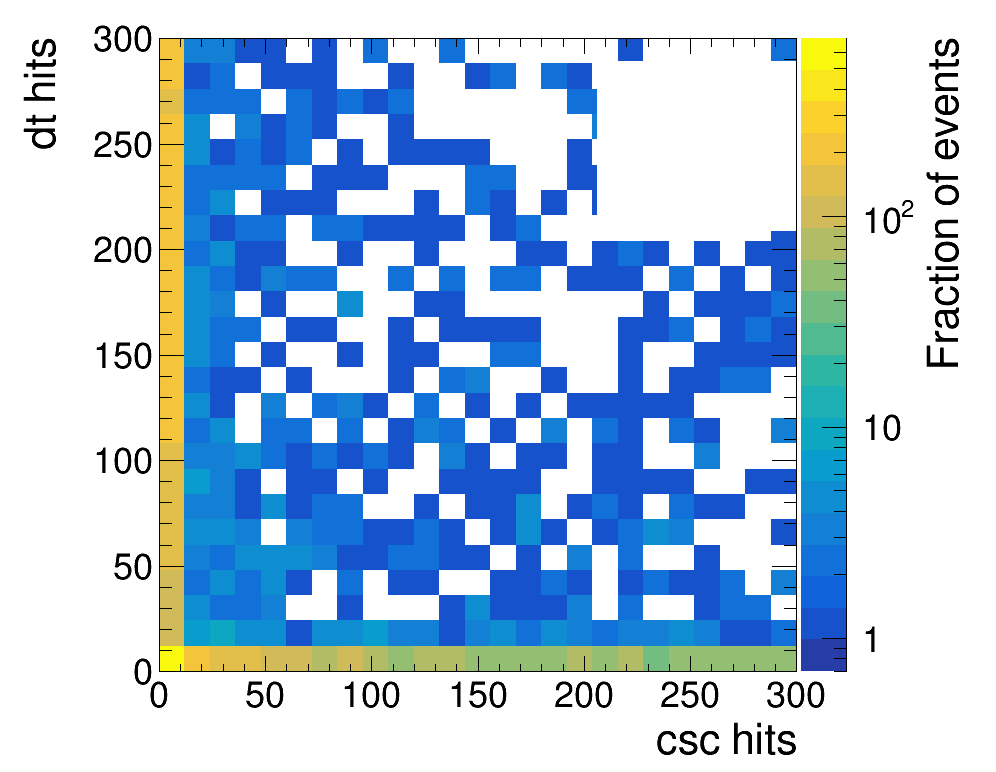

In [56]:


# var = [gLLP_eta, gLLP_decay_vertex_r, gLLP_decay_vertex_z, gLLP_match_cscRechits, gLLP_match_dtRechits]
# name = ['gLLP_eta', 'gLLP_decay_vertex_r', 'gLLP_decay_vertex_z', 'gLLP_match_cscRechits', 'gLLP_match_dtRechits', 'cscRechitClusterMe11Ratio',\
#        'deltaRCluster', 'deltaEta', 'cscRechitClusterEta', 'cscRechitClusterPhi', 'cscRechitClusterAvgStation', 'clusterDphi']

# xaxis = ['cluster time [ns]', 'max cluster time spread [ns]', 'max jet veto p_{T} [GeV]','max muon veto p_{T} [GeV]', 'max #Delta#phi(met, cluster)', 'max N_{ME11 hits}/N_{rechits}',\
#         '#Delta R(cluster1, cluster2)', '#Delta#eta(cluster1, cluster2)', 'cluster #eta', 'cluster #phi', 'cluster average station', '#Delta#phi(cluster1, cluster2)']

# # bins = [ [100,-100,120], [50,0,100], [50,0,500],[50,0,200], [32,0,3.2], [25,0,1.1],[25,0.8,2.5],[30,0,3.2],[35,1,4], [40,0,3.2], [40,0,8], [40,0,5]]

# bins = [ [100,-100,120], [50,0,100], [50,0,500],[50,0,200], [32,0,3.2], [22,0,1.1],[40,0,8], [40,0,5], [25,0.8,2.5],[25,0,3.2],[20,1,4], [25,0,3.2]]

# setlogy = [1,1,1,1,1,1,1,1,1,1,1,1]

c = rt.TCanvas('c','c', 1000, 800)
leg = rt.TLegend(0.6,0.7,0.80,0.92)

#     leg = rt.TLegend(0.5,0.56,0.75,0.92)

leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
h = {}

for i, k in enumerate(tree.keys()):
    if not k == 'm40ctau1000':continue

    eta_overlap = np.logical_and(np.abs(gLLP_eta[k]).flatten()<1.3, np.abs(gLLP_eta[k]).flatten()>0.7)
    h[k] = create_TH2D(np.column_stack((gLLP_match_cscRechits[k], gLLP_match_dtRechits[k])), axis_title = ['csc hits','dt hits', 'Fraction of events'], binning = [25,0,300, 25, 0,300])


    h[k].Draw('colz')

leg.Draw()
c.SetRightMargin(0.2)
c.SetLogz()

c.Draw()
#     plot_path = '/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/selection_plots'
#     c.SaveAs(plot_path+v2+'/csccsc_'+name[index]+".png")
#     c.SaveAs(plot_path+v2+'/csccsc_'+name[index]+".pdf")
#     c.SaveAs(plot_path+v2+'/csccsc_'+name[index]+".C")




In [ ]:
    print(k, np.count_nonzero(np.logical_and(np.abs(gLLP_match_cscRechits[k]).flatten()>50, gLLP_match_cscRechits[k]>50))/len(gLLP_eta[k].flatten()))


1.3524753
0.7649529


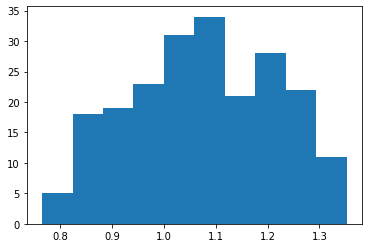

In [41]:
plt.hist(np.abs(gLLP_eta[k])[np.logical_and(np.abs(gLLP_match_cscRechits[k]).flatten()>50, gLLP_match_dtRechits[k]>50)])
print(np.max(np.abs(gLLP_eta[k])[np.logical_and(np.abs(gLLP_match_cscRechits[k]).flatten()>50, gLLP_match_dtRechits[k]>50)]))
print(np.min(np.abs(gLLP_eta[k])[np.logical_and(np.abs(gLLP_match_cscRechits[k]).flatten()>50, gLLP_match_dtRechits[k]>50)]))
plt.show()

# different detector same mass

[   100   1000  10000 100000] [0.01759002 0.18113007 0.04129853 0.00455914]
[   100   1000  10000 100000] [0.0967126  0.15541549 0.02911568 0.00320182]
[   100   1000  10000 100000] [4.87779500e-03 3.16206664e-02 1.10711157e-03 1.10603705e-05]
[   100   1000  10000 100000] [0.00138001 0.16794348 0.07747072 0.00964735]
[   100   1000  10000 100000] [0.03778148 0.19084354 0.05851958 0.00698627]
[   100   1000  10000 100000] [1.2379832e-03 3.6634870e-02 4.3987529e-03 5.6837234e-05]
[   100   1000  10000 100000] [1.9385270e-05 3.8945861e-02 1.2929241e-01 2.3429826e-02]
[   100   1000  10000 100000] [0.00571751 0.14890444 0.1436274  0.02297585]
[   100   1000  10000 100000] [0.00010771 0.01191257 0.02160922 0.00054888]
[   100   1000  10000 100000] [1.2488442e-06 1.0095874e-02 1.0753845e-01 2.9417366e-02]
[   100   1000  10000 100000] [0.00214932 0.10795941 0.19298339 0.03991914]
[   100   1000  10000 100000] [4.3224929e-05 9.5031103e-03 2.9889448e-02 1.5888559e-03]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/dt/acceptance/mass7_2tagtotal.png has been created
Info in <TCanvas::SaveSource>: C++ Macro file: /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/dt/acceptance/mass7_2tagtotal.C has been generated
Info in <TCanvas::Print>: pdf file /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/dt/acceptance/mass7_2tagtotal.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/dt/acceptance/mass15_2tagtotal.png has been created
Info in <TCanvas::SaveSource>: C++ Macro file: /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/dt/accep

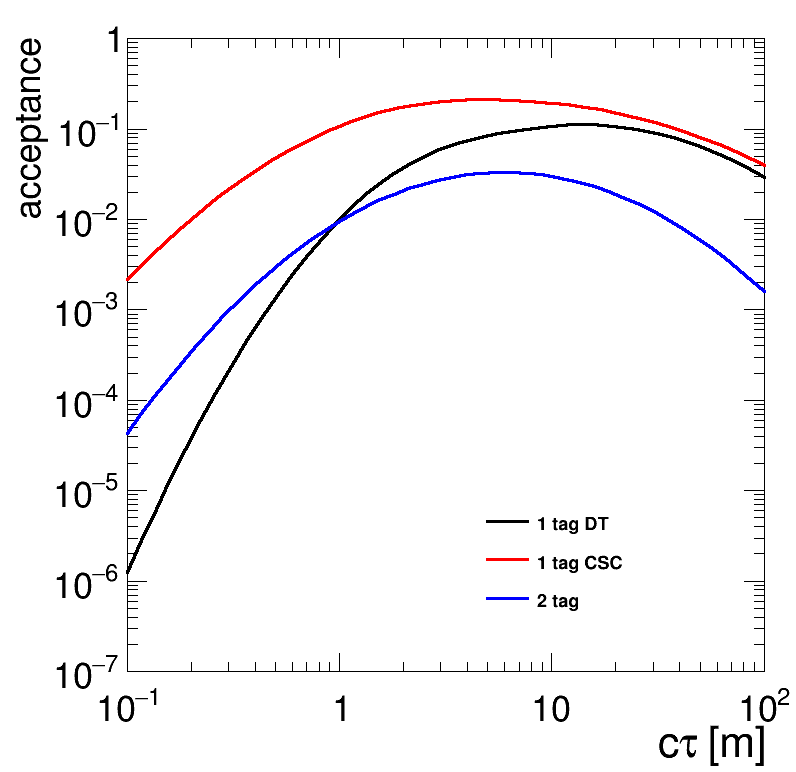

In [13]:
import os


met = False
total = True

if total:
    names = ['1 tag DT', '1 tag CSC', '2 tag ']
    if met:variables = [accep_met_dt1,accep_met_csc1, accep_met_2tag]
    else: variables = [acceptance_dt1, acceptance_csc1, acceptance_2tag]



else:
    names = ['1 tag DT', '1 tag CSC', '2 tag DT', '2 tag CSC', '1 tag DT + 1 tag CSC']
    if met:variables = [accep_met_dt1,accep_met_csc1, accep_met_dt2, accep_met_csc2, accep_met_cross]
    else: variables = [acceptance_dt1, acceptance_csc1, acceptance_dt2, acceptance_csc2, acceptance_cross]
    
    

for j, m in enumerate(mass):
    
#     if not j == 1:continue
    c = rt.TCanvas('c','c', 800, 800)
    c.SetRightMargin(0.04)
    rt.gStyle.SetOptFit(1011)
    leg = rt.TLegend(0.6,0.2,0.9,0.35)
    leg.SetTextSize(0.025)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    h = {}
    for i, var in enumerate(variables):


        y = np.array([var['m'+m+'ctau100'], var['m'+m+'ctau1000'], var['m'+m+'ctau10000'], var['m'+m+'ctau100000']])
        x = np.array([int(a) for a in ctaus])
        
        cond = y>0.0
        print(x, y)
        h[m+str(i)] = create_TGraph(x[cond]/1000.0, y[cond],  axis_title=['c#tau [m]', 'acceptance'])


        h[m+str(i)].SetLineColor(std_color_list[i])
        h[m+str(i)].SetLineWidth(3)
        h[m+str(i)].GetXaxis().SetTitleOffset(1)
        h[m+str(i)].GetYaxis().SetTitleSize(0.05)
        h[m+str(i)].GetYaxis().SetTitleOffset(1.5)
        h[m+str(i)].GetXaxis().SetLimits(0.1,100.0)
        if met:h[m+str(i)].GetYaxis().SetRangeUser(1e-8,0.01)
        else: h[m+str(i)].GetYaxis().SetRangeUser(1e-7,1)
        leg.AddEntry(h[m+str(i)], names[i], "L")


    for i,k in enumerate(h.keys()):
        h[k].Draw('CA' if i == 0 else 'Csame')

    leg.Draw()
    c.SetLogy()
    c.SetLogx()
    c.SetTicky(1)
    c.SetTickx(1)
    
    if met: output_dir = '/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/dt/acceptance_met/'
    else: output_dir = '/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/dt/acceptance/'
    if not os.path.isdir(output_dir):os.makedirs(output_dir)
    name = output_dir+'mass'+m

    if total:
        c.SaveAs(name+'_2tagtotal.png')
        c.SaveAs(name+'_2tagtotal.C')
        c.SaveAs(name+'_2tagtotal.pdf')
    else:
        c.SaveAs(name+'.png')
        c.SaveAs(name+'.C')
        c.SaveAs(name+'.pdf')

    c.Draw()





[   100   1000  10000 100000] [0.00051871 0.00245022 0.0008714  0.00010995]
[   100   1000  10000 100000] [6.1465416e-04 1.6119396e-03 5.4284831e-04 6.6587017e-05]
[   100   1000  10000 100000] [2.8408962e-05 4.3636872e-04 2.3566145e-05 4.5320724e-07]
[   100   1000  10000 100000] [2.7982485e-06 2.0721632e-04 1.0815684e-05 2.7317640e-07]
[   100   1000  10000 100000] [2.4624309e-05 8.4504209e-05 3.6569836e-06 1.8003082e-07]
[   100   1000  10000 100000] [9.8640521e-07 1.4464819e-04 9.0934773e-06 0.0000000e+00]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


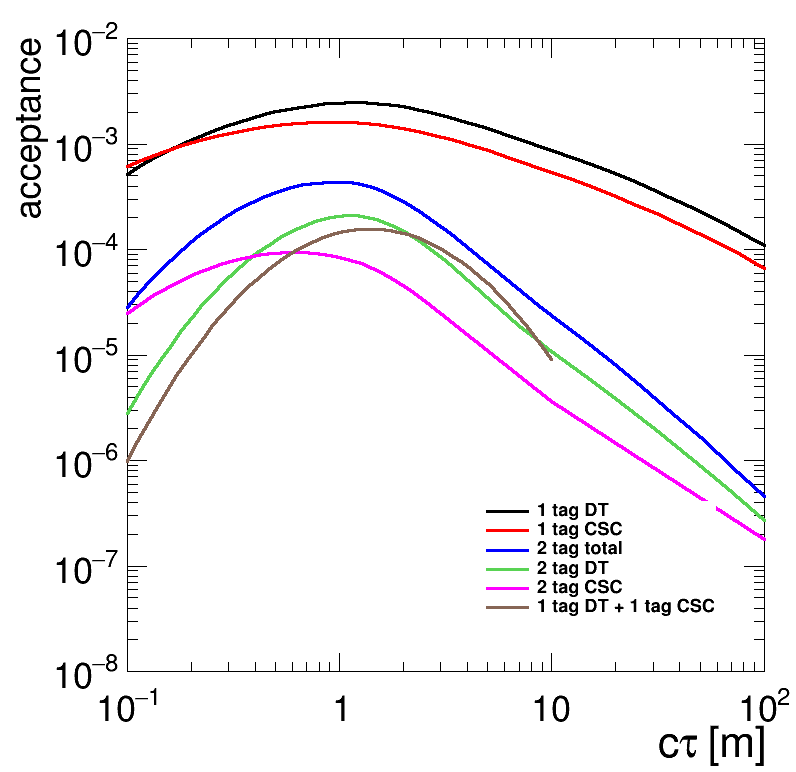

In [6]:
import os


met = 1


names = ['1 tag DT', '1 tag CSC', '2 tag total', '2 tag DT', '2 tag CSC', '1 tag DT + 1 tag CSC']
if met:variables = [accep_met_dt1,accep_met_csc1, accep_met_2tag, accep_met_dt2, accep_met_csc2, accep_met_cross]
else: variables = [acceptance_dt1, acceptance_csc1, acceptance_2tag, acceptance_dt2, acceptance_csc2, acceptance_cross]
    
    

for j, m in enumerate(mass):
    
    if not m == '15':continue
    c = rt.TCanvas('c','c', 800, 800)
    c.SetRightMargin(0.04)
    rt.gStyle.SetOptFit(1011)
    leg = rt.TLegend(0.6,0.2,0.9,0.35)
    leg.SetTextSize(0.025)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    h = {}
    for i, var in enumerate(variables):


        y = np.array([var['m'+m+'ctau100'], var['m'+m+'ctau1000'], var['m'+m+'ctau10000'], var['m'+m+'ctau100000']])
        x = np.array([int(a) for a in ctaus])
        
        cond = y>0.0
        print(x, y)
        h[m+str(i)] = create_TGraph(x[cond]/1000.0, y[cond],  axis_title=['c#tau [m]', 'acceptance'])


        h[m+str(i)].SetLineColor(std_color_list[i])
        h[m+str(i)].SetLineWidth(3)
        h[m+str(i)].GetXaxis().SetTitleOffset(1)
        h[m+str(i)].GetYaxis().SetTitleSize(0.05)
        h[m+str(i)].GetYaxis().SetTitleOffset(1.5)
        h[m+str(i)].GetXaxis().SetLimits(0.1,100.0)
        if met:h[m+str(i)].GetYaxis().SetRangeUser(1e-8,0.01)
        else: h[m+str(i)].GetYaxis().SetRangeUser(1e-7,1)
        leg.AddEntry(h[m+str(i)], names[i], "L")


    for i,k in enumerate(h.keys()):
        h[k].Draw('CA' if i == 0 else 'Csame')

    leg.Draw()
    c.SetLogy()
    c.SetLogx()
    c.SetTicky(1)
    c.SetTickx(1)
    
#     if met: output_dir = '/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/dt/acceptance_met/'
#     else: output_dir = '/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/dt/acceptance/'
#     if not os.path.isdir(output_dir):os.makedirs(output_dir)
#     name = output_dir+'mass'+m

#     if total:
#         c.SaveAs(name+'_all.png')
#         c.SaveAs(name+'_all.C')
#         c.SaveAs(name+'_all.pdf')
#     else:
#         c.SaveAs(name+'.png')
#         c.SaveAs(name+'.C')
#         c.SaveAs(name+'.pdf')

    c.Draw()






# hepdata plot for EXO-20-015

[       5       10       15       20       30       40       50       60
      100      125      150      200      300      500      600      700
      800      900     1000     2000     3000     4000     5000     6000
     7000     8000    10000    20000    30000    50000   100000   200000
   300000   500000  1000000  2000000  3000000  5000000  6000000 10000000]
[       5       10       15       20       30       40       50       60
      100      125      150      200      300      500      600      700
      800      900     1000     2000     3000     4000     5000     6000
     7000     8000    10000    20000    30000    50000   100000   200000
   300000   500000  1000000  2000000  3000000  5000000  6000000 10000000]
[       5       10       15       20       30       40       50       60
      100      125      150      200      300      500      600      700
      800      900     1000     2000     3000     4000     5000     6000
     7000     8000    10000    20000    30000    

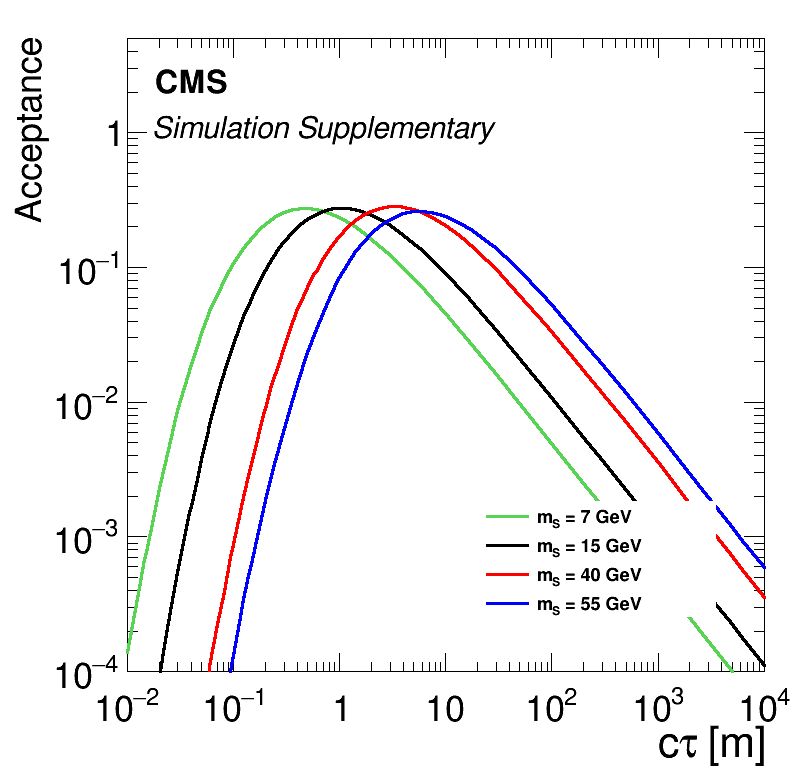

In [4]:
import numpy.ma as ma
import ROOT as rt
import os
import importlib
import math
sys.path.append('/storage/af/user/christiw/login-1/christiw/LLP/CMSSW_9_4_4/src/llp_analyzer/python/')

from helper import  weight_calc

importlib.reload(sys.modules['CMS_lumi'])


OLD_CTAU= [100,1000,10000,100000]



leg = rt.TLegend(0.6,0.2,0.9,0.35)
leg.SetTextSize(0.025)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
c = rt.TCanvas('c','c', 800, 800)
c.SetRightMargin(0.04)
rt.gStyle.SetOptFit(1011)
h = {}

ctaus = ['5','10','15','20','30','40', '50','60', '100', '125','150','200','300','500','600','700','800','900','1000', '2000','3000','4000', '5000', '6000','7000','8000','10000', '20000','30000','50000',\
         '100000', '200000', '300000', '500000', '1000000', '2000000', '3000000', '5000000', '6000000', '10000000'] #mm
acceptance = {}

for i, m in enumerate(mass):
    acceptance[m] = []
    #ctau reweighting
    for ct in ctaus:
        accep_temp = 0
        ctf = int(ct)
        ct_list = 10**int(math.log10(ctf))
        if ctf < OLD_CTAU[0]: ct_list = [OLD_CTAU[0]]
        elif ctf>OLD_CTAU[-1]: ct_list = [OLD_CTAU[-1]]
        elif ct_list == int(ct): ct_list = [int(ct)]
        else:ct_list = [ct_list,ct_list*10]
   
        
        for j, ct0 in enumerate(ct_list):
            k = 'm'+str(m)+'ctau'+str(ct0)
            T = tree[k]
            if np.count_nonzero(sel_ev_csc1[k])==0:continue
            gLLP_ctau = T.array('gLLP_ctau')[sel_ev_csc1[k]]
            weight_ctau = weight_calc(gLLP_ctau, int(ct)/10, int(ct0)/10) # convert everything to cm
            gLLP_ctau = np.sum(T.array('gLLP_ctau'), axis = 1)[sel_ev_csc1[k]]
            if len(ct_list) == 1:weight_cond = gLLP_ctau >= 0
            else:
                if j == 0 : weight_cond = gLLP_ctau<int(ct_list[0]/2)
                else: weight_cond = gLLP_ctau>=int(ct_list[0]/2)
            weight = (T.array('weight')*T.array('higgsPtWeight'))[sel_ev_csc1[k]]
            w = (weight*weight_ctau)[weight_cond]
            accep_temp += np.sum(w)
        acceptance[m].append(accep_temp/6664892.0)
#         print(ct, m, acceptance[m][-1])
    
    #######################
    
#     y = np.array([acceptance_csc1['m'+m+'ctau100'], acceptance_csc1['m'+m+'ctau1000'], acceptance_csc1['m'+m+'ctau10000'], acceptance_csc1['m'+m+'ctau100000']])
    x = np.array([int(a) for a in ctaus])
    y = np.array(acceptance[m])
    cond = y>0.0
    print(x)
    h[m] = create_TGraph(x[cond]/1000.0, y[cond],  axis_title=['c#tau [m]', 'Acceptance'])


    if i == 0:h[m].SetLineColor(std_color_list[3])
    else:h[m].SetLineColor(std_color_list[i-1])

    h[m].SetLineWidth(3)
    h[m].GetXaxis().SetTitleOffset(1)
    h[m].GetYaxis().SetTitleSize(0.05)
    h[m].GetYaxis().SetTitleOffset(1.5)
    h[m].GetXaxis().SetLimits(0.01,10000.0)
    h[m].GetYaxis().SetRangeUser(1e-4,5)
    leg.AddEntry(h[m], "m_{S} = "+str(m)+" GeV", "L")

    
    ###### save to text file for hepdata ######
    outputDir = '/storage/af/user/christiw/login-1/christiw/LLP/CMSSW_9_4_4/src/llp_analyzer/data/SupplementaryMaterials/'
    if not os.path.isdir(outputDir):os.makedirs(outputDir)
    outputFileName = outputDir + 'acceptance_m'+str(m)
    outputFileName += '.txt'
    np.savetxt(outputFileName, np.column_stack((x[cond]/1000.0, y[cond])), delimiter="\t")


for i,m in enumerate(h.keys()):
    h[m].Draw('CA' if i == 0 else 'Csame')
#     h[m].Draw('LA' if i == 0 else 'Lsame')

CMS_lumi.cmsText     = "CMS"
CMS_lumi.iPos=11
CMS_lumi.relPosX = 0.1
CMS_lumi.relPosY = 0.05        
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText   = "Simulation Supplementary"
CMS_lumi.CMS_lumi(c, 0, 11)

leg.Draw()


c.SetLogy()
c.SetLogx()
c.SetTicky(1)
c.SetTickx(1)
# output_dir = '/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/csc/acceptance/'
# if not os.path.isdir(output_dir):os.makedirs(output_dir)
    
# name = output_dir+names[j]
# print(name)


#     c.SaveAs(name+'.png')
#     c.SaveAs(name+'.C')
#     c.SaveAs(name+'.pdf')
c.Draw()





Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/acceptance/csc_acceptance.png has been created
Info in <TCanvas::SaveSource>: C++ Macro file: /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/acceptance/csc_acceptance.C has been generated
Info in <TCanvas::Print>: pdf file /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/acceptance/csc_acceptance.pdf has been created


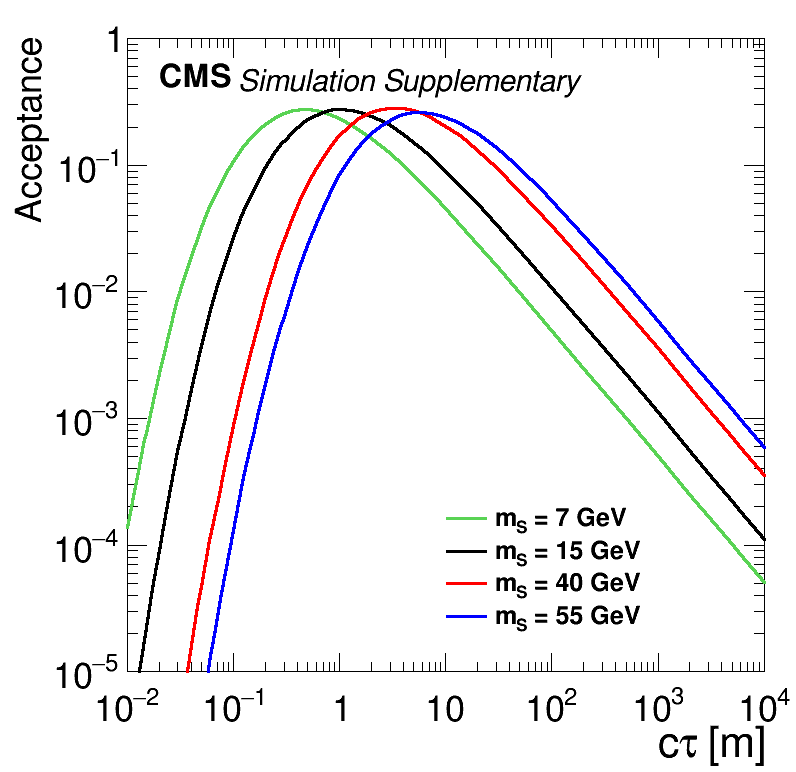

In [14]:
importlib.reload(sys.modules['CMS_lumi'])


leg = rt.TLegend(0.55,0.18,0.84,0.35)
# leg = rt.TLegend(0.7,0.75,0.84,0.9)
leg.SetTextSize(0.035)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)

c = rt.TCanvas('c','c', 800, 800)
c.SetRightMargin(0.04)
rt.gStyle.SetOptFit(1011)
for i,m in enumerate(h.keys()):
    if i == 0:h[m].SetLineColor(std_color_list[3])
    else:h[m].SetLineColor(std_color_list[i-1])
#     h[m].GetXaxis().SetLimits(0.01,10000.0)
    h[m].GetYaxis().SetRangeUser(1e-5,1)
    leg.AddEntry(h[m], "m_{S} = "+str(m)+" GeV", "L")

    h[m].Draw('CA' if i == 0 else 'Csame')
#     h[m].Draw('LA' if i == 0 else 'Lsame')


CMS_lumi.cmsText     = "CMS"
CMS_lumi.iPos=11
CMS_lumi.relPosX = 0.05
CMS_lumi.relPosY = 0.041      
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText   = "Simulation Supplementary"
CMS_lumi.CMS_lumi(c, 0, 10)

leg.Draw()


c.SetLogy()
c.SetLogx()
c.SetTicky(1)
c.SetTickx(1)
output_dir = '/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/acceptance/'
if not os.path.isdir(output_dir):os.makedirs(output_dir)
    
# name = output_dir+names[j]
# print(name)


c.SaveAs(output_dir+'csc_acceptance.png')
c.SaveAs(output_dir+'csc_acceptance.C')
c.SaveAs(output_dir+'csc_acceptance.pdf')
c.Draw()



